In [2]:
# Import necessary libraries and suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')  # For environments that require a non-interactive backend
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # When only plt is used

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report

# Ensure inline plotting on Kaggle
%matplotlib inline

# Set plot styling
sns.set(style='whitegrid')

In [3]:
# Load the data
data_path = './telesurgery_cybersecurity_dataset.csv'
df = pd.read_csv(data_path, encoding='ascii', delimiter=',')

# Display first few rows
df.head()

,Robot Gesture ID,Gesture Type,"Gesture Coordinates (x, y, z)",Timestamp,Gesture Duration (sec),Robot Status,Message ID,Sender,Receiver,Encryption Algorithm Used,Encryption Status,Network Latency (ms),Data Transfer Rate (Mbps),Threat Type,Threat Severity,Response Time (sec),Response Action Taken,Threat Detected
0,10,Incision,"(1.48, 1.4, 0.02)",2025-02-14 16:32:27,4.37,Idle,22614,Operator,Robot,Two Fish,Encrypted,11,97,Man-in-the-Middle Attack,Low,4.63,Reset Encryption,1
1,8,Diagnosis,"(1.62, 1.81, 0.68)",2025-02-14 16:32:27,3.08,Idle,61556,Operator,Robot,Two Fish,Encrypted,9,88,DoS Attack,Low,3.94,Reset Encryption,1
2,9,Incision,"(0.67, 1.53, 0.06)",2025-02-14 16:32:27,1.11,Active,27848,Operator,Robot,Two Fish,Encrypted,7,26,No Threat,Low,0.00,NaN,0
3,1,Incision,"(1.63, 1.74, 1.92)",2025-02-14 16:32:27,2.72,Idle,60592,Operator,Robot,Two Fish,Encrypted,13,56,Data Breach,High,4.58,Reconnect Connection,1
4,4,Suturing,"(0.53, 0.87, 1.17)",2025-02-14 16:32:27,1.20,Idle,46712,Robot,Operator,Two Fish,Failed,5,41,Man-in-the-Middle Attack,Low,2.46,Isolate Data,1


In [4]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Check if any dates did not parse correctly
if df['Timestamp'].isnull().sum() > 0:
    print('Some Timestamp values could not be converted and are set as NaT')

# Parse the 'Gesture Coordinates (x, y, z)' column by splitting into three new columns
def parse_coordinates(coord_str):
    # Remove potential parentheses and extra whitespace
    coord_str = coord_str.replace('(', '').replace(')', '')
    parts = [float(x) for x in coord_str.split(',')]
    if len(parts) != 3:
        # In case the delimiter or structure is non-standard, this error will help track the issue
        return pd.Series([np.nan, np.nan, np.nan])
    return pd.Series(parts, index=['Coord_X', 'Coord_Y', 'Coord_Z'])

df[['Coord_X', 'Coord_Y', 'Coord_Z']] = df['Gesture Coordinates (x, y, z)'].apply(parse_coordinates)

# Print summary of missing values
print('Missing values per column:')
print(df.isnull().sum())

Missing values per column:
Robot Gesture ID                   0
Gesture Type                       0
Gesture Coordinates (x, y, z)      0
Timestamp                          0
Gesture Duration (sec)             0
Robot Status                       0
Message ID                         0
Sender                             0
Receiver                           0
Encryption Algorithm Used          0
Encryption Status                  0
Network Latency (ms)               0
Data Transfer Rate (Mbps)          0
Threat Type                        0
Threat Severity                    0
Response Time (sec)                0
Response Action Taken            283
Threat Detected                    0
Coord_X                            0
Coord_Y                            0
Coord_Z                            0
dtype: int64


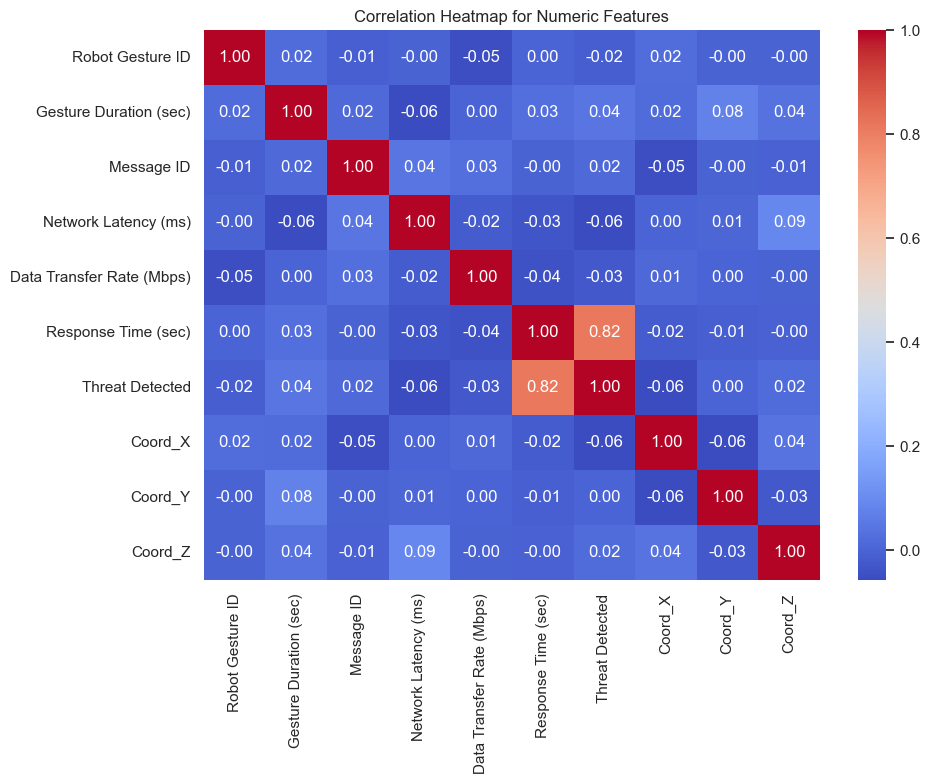

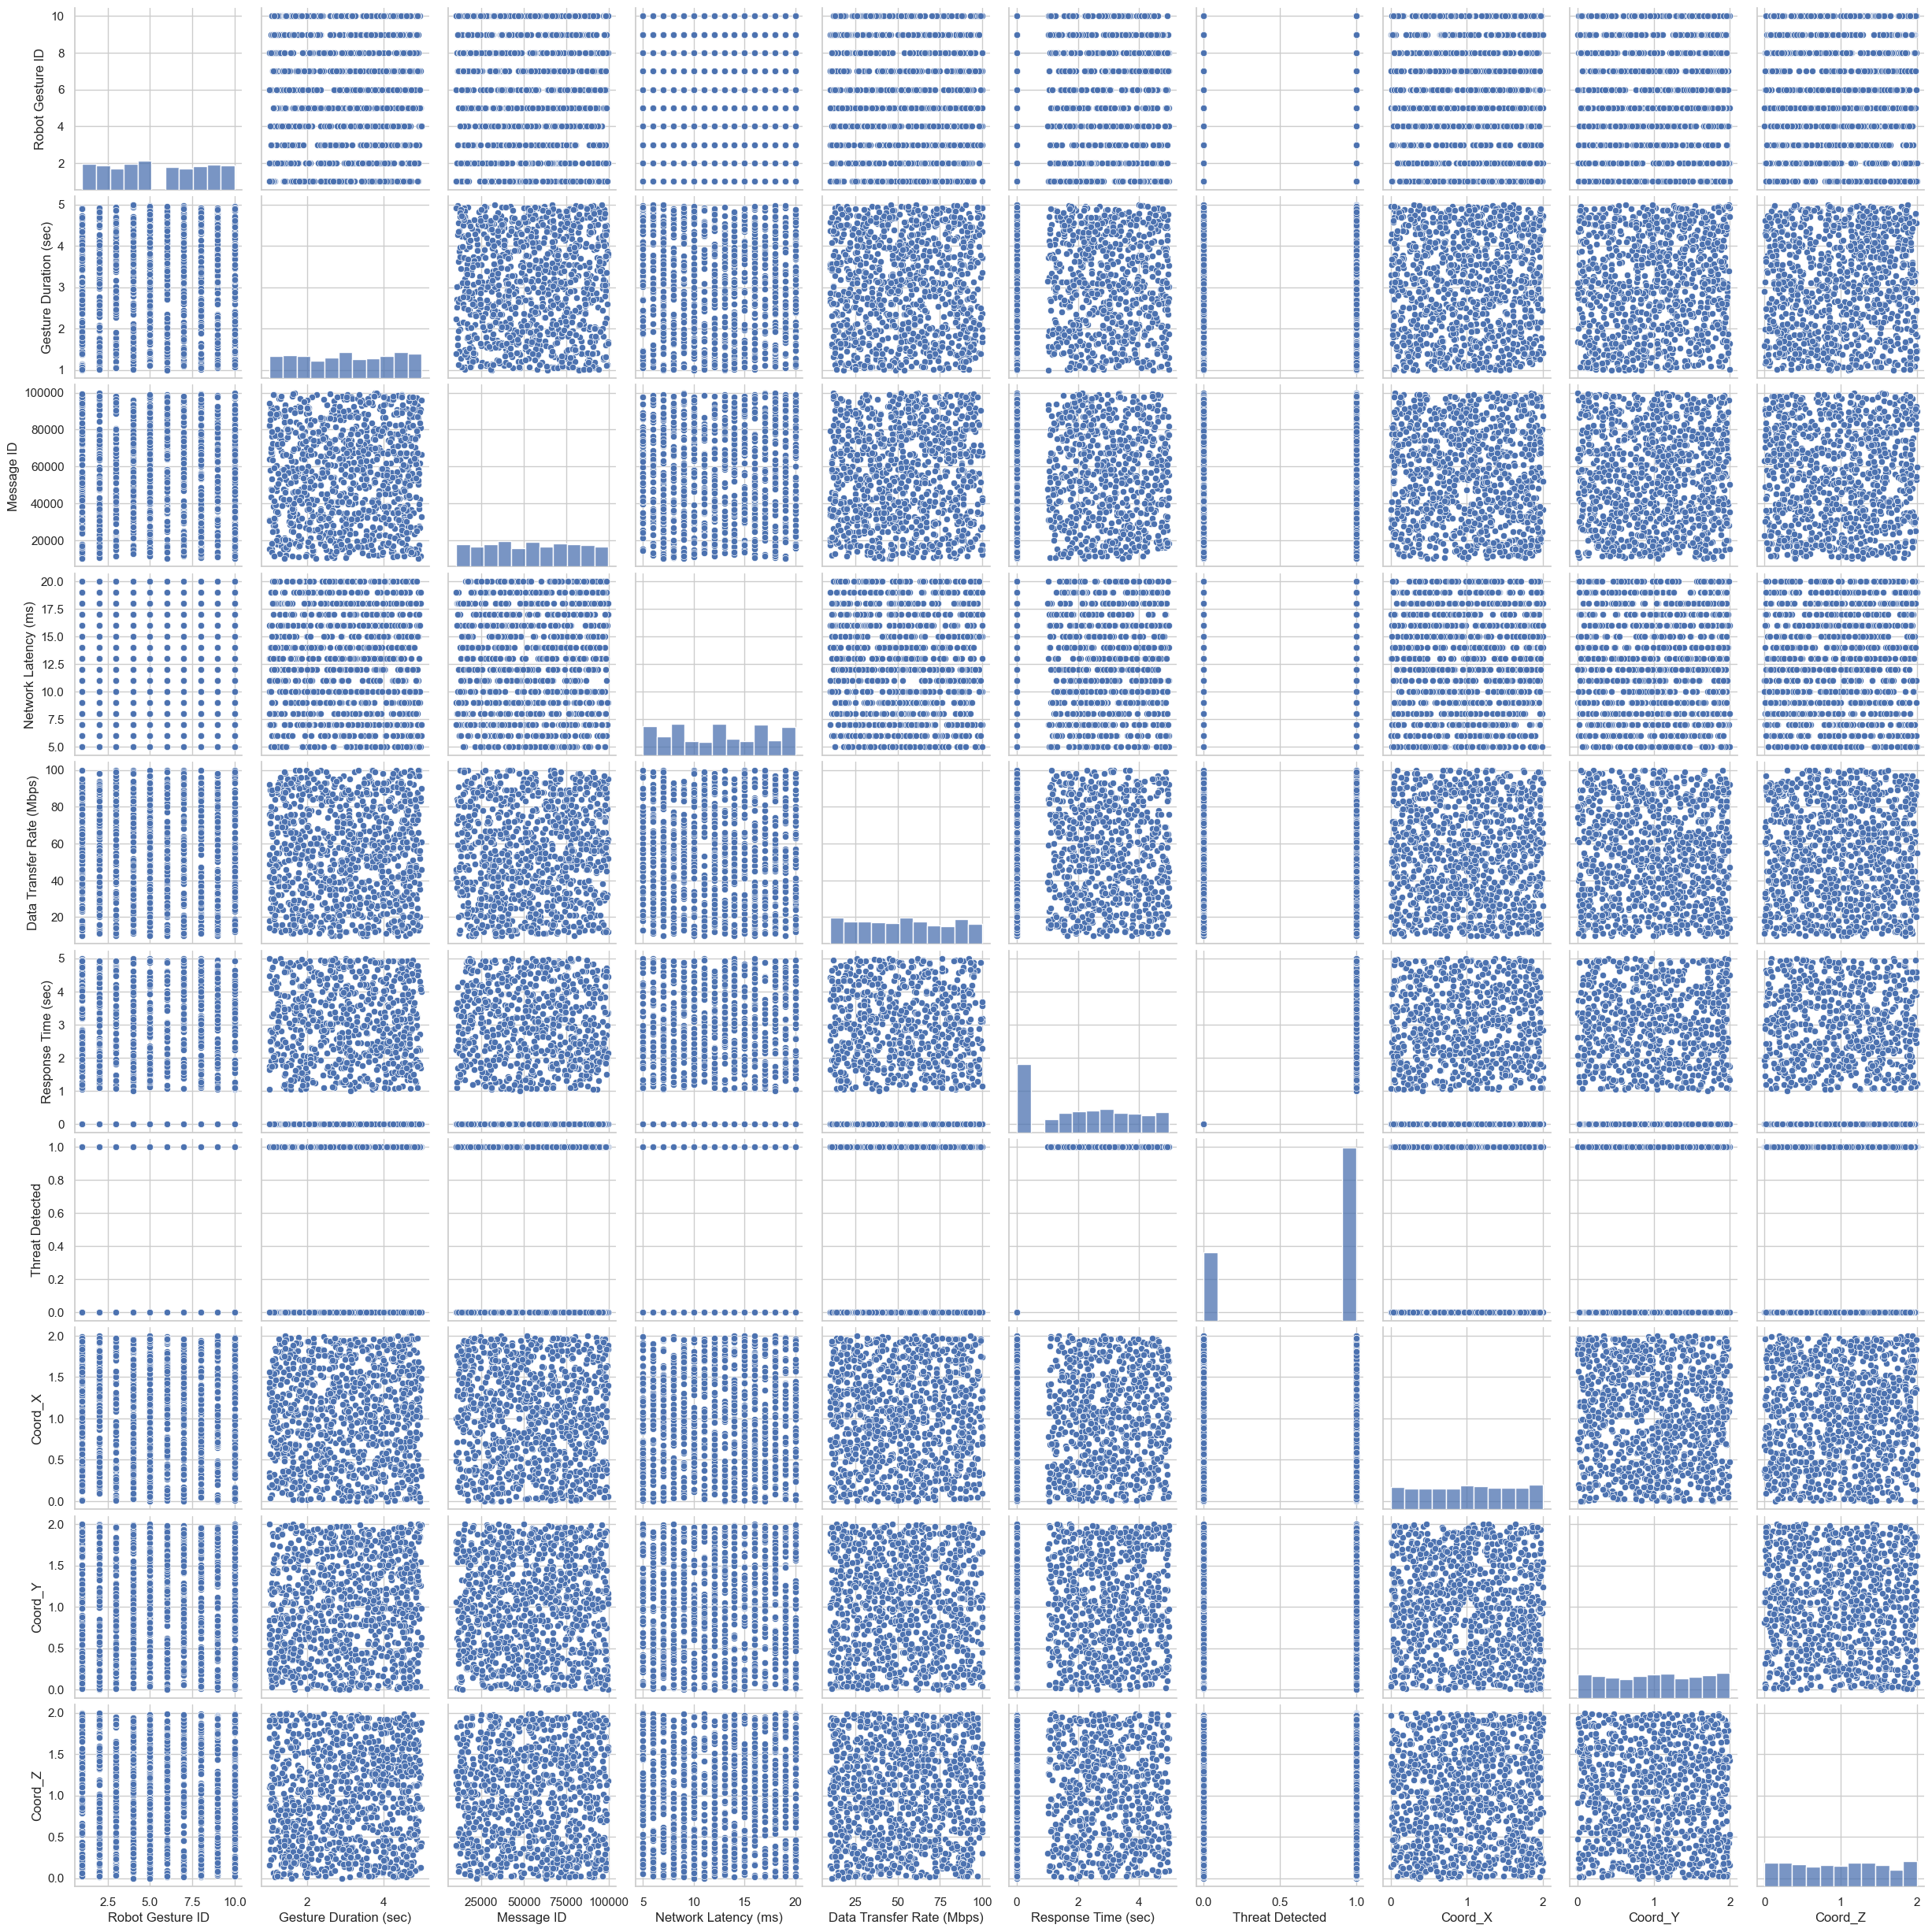

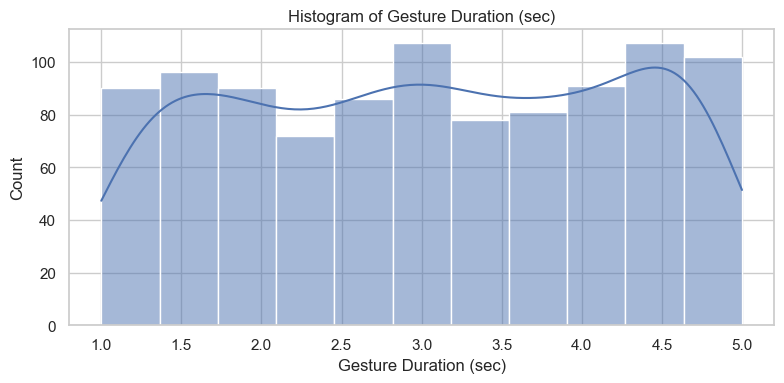

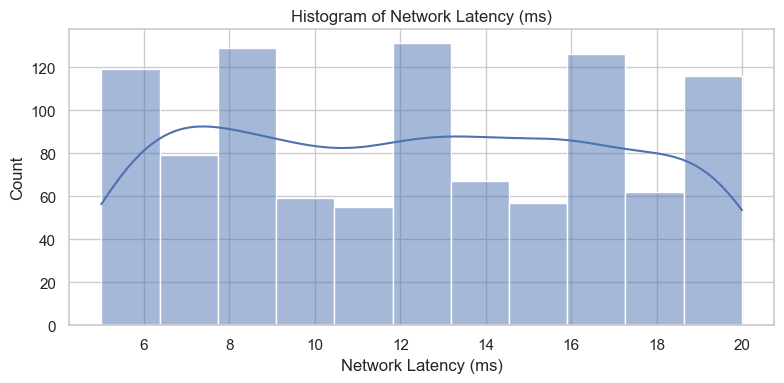

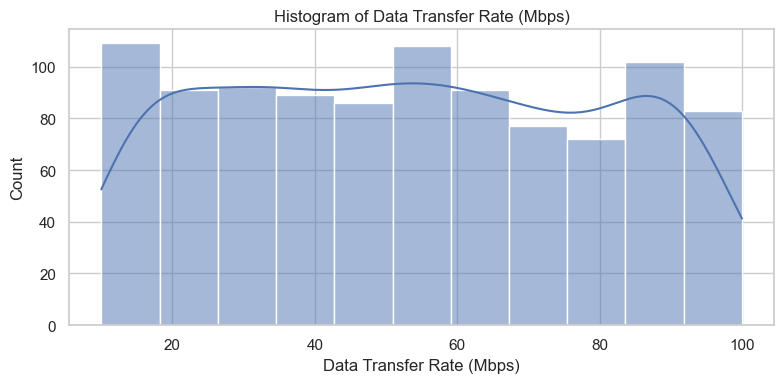

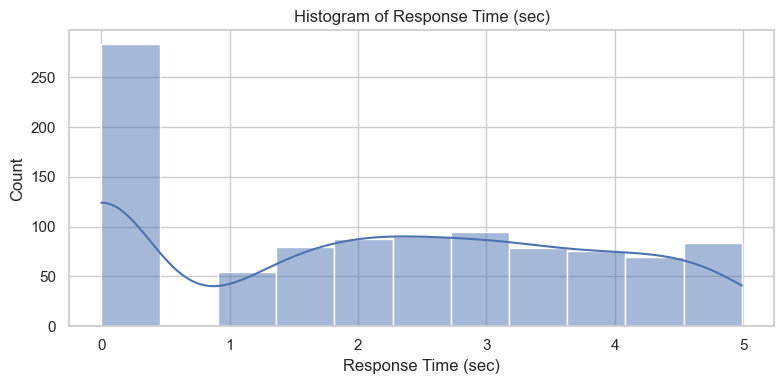

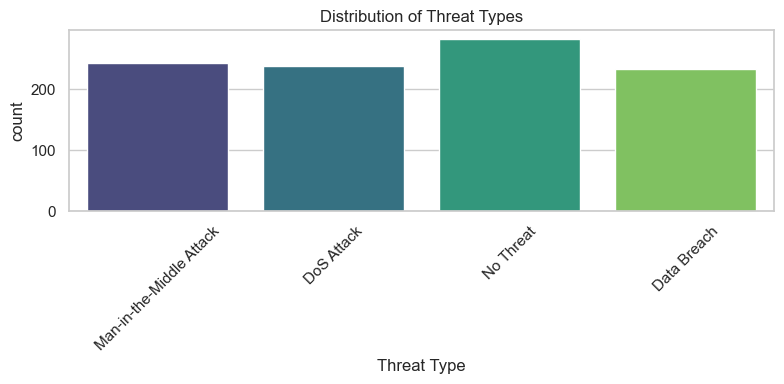

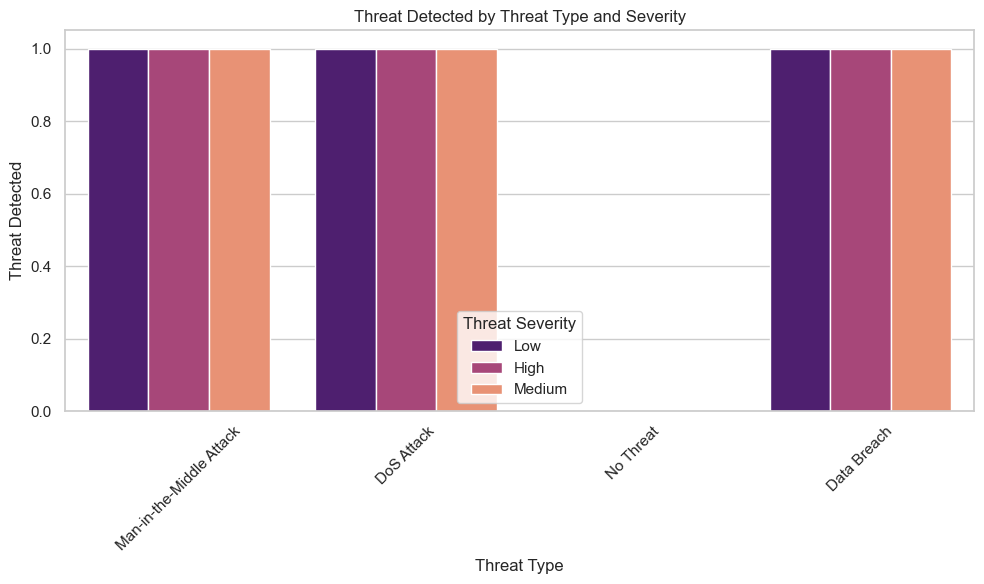

In [5]:
# Extract numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=[np.number])

# Plot correlation heatmap (only if at least 4 numeric columns exist)
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap for Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a correlation heatmap.')

# Pair Plot for numeric features
sns.pairplot(numeric_df.dropna())
plt.show()

# Histogram for selected numeric features
numeric_features = ['Gesture Duration (sec)', 'Network Latency (ms)', 'Data Transfer Rate (Mbps)', 'Response Time (sec)']
for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature].dropna(), kde=True)
    plt.title(f'Histogram of {feature}')
    plt.tight_layout()
    plt.show()

# Count plot (Pie Chart style) for Threat Type
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Threat Type', palette='viridis')
plt.title('Distribution of Threat Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Grouped barplot for Threat Severity by Threat Type
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Threat Type', y='Threat Detected', hue='Threat Severity', palette='magma')
plt.title('Threat Detected by Threat Type and Severity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Select features and target for modeling
features = ['Gesture Duration (sec)', 'Network Latency (ms)', 'Data Transfer Rate (Mbps)', 'Response Time (sec)']
target = 'Threat Detected'

# Drop rows with missing values in the selected features or target
model_df = df[features + [target]].dropna()

# Split the data into training and testing sets
X = model_df[features]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building a pipeline with standard scaling and logistic regression
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42))
])

# Train the predictor
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate accuracy score
acc = accuracy_score(y_test, y_pred)
print(f'Prediction Accuracy: {acc:.2f}')

# Display a classification report
print(classification_report(y_test, y_pred))

Prediction Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00       150

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



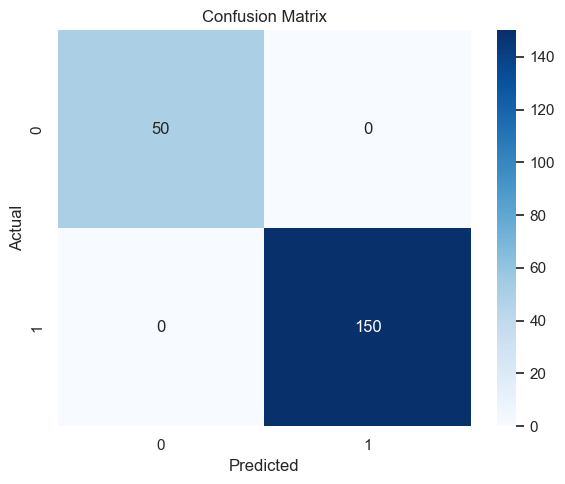

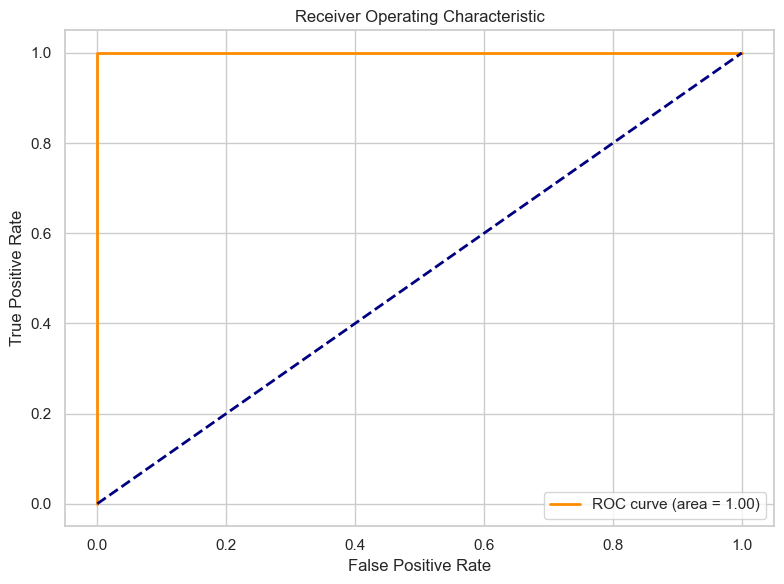

In [7]:
# Confusion Matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curve visualization
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()